# Filtering on CPUs versus GPUs

This tutorial gives a quick introduction to using `gcm-filters` on either CPU's or GPU's.

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

## POP data

We are going to work with data from the CORE-forced Parallel Ocean Program (POP) simulation described in [Johnson et al. (2016)](https://journals.ametsoc.org/view/journals/phoc/46/10/jpo-d-15-0202.1.xml). The corresponding grid is the 0.1 degree nominal resolution POP tripole grid ([Smith et al., 2010](https://www.cesm.ucar.edu/models/cesm1.0/pop2/doc/sci/POPRefManual.pdf)). SST snapshot data and grid variables are stored in the following dataset, which we pull from figshare.

In [2]:
import requests 
r = requests.get('https://ndownloader.figshare.com/files/28041441')
with open('POP_SST.nc', 'wb') as fp:
    fp.write(r.content)

In [3]:
ds = xr.open_dataset('POP_SST.nc')
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 1, z_t: 62)
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) float64 ...
    TAREA    (nlat, nlon) float64 ...
    HTN      (nlat, nlon) float64 ...
    HTE      (nlat, nlon) float64 ...
    HUS      (nlat, nlon) float64 ...
    HUW      (nlat, nlon) float64 ...
    SST      (time, nlat, nlon) float32 ...
Attributes:
    title:           g.e01.GIAF.T62_t12.003
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 46405 2013-04-26 05:24:34Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2014-07-19 at 17:28:03.3
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9618241
    tavg_sum:        431999.9999999717
    tavg_sum_qflux:  432000.00000000006

In this example, we want to **filter** SST **with a fixed factor of 10**, i.e., to nominally 1 degree resolution.

To keep things simple, we will filter with the **simple fixed factor filter**. The `TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND` Laplacian is suitable for this filter and our data on a tripole grid. This Laplacian only needs the grid cell `area` and `wet_mask` as grid input variables.

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND)

['area', 'wet_mask']

`wet_mask` is a mask that is 1 in ocean T-cells, and 0 in land T-cells. Since we only want to filter temperature in the uppermost level, we only need a 2D `wet_mask`.

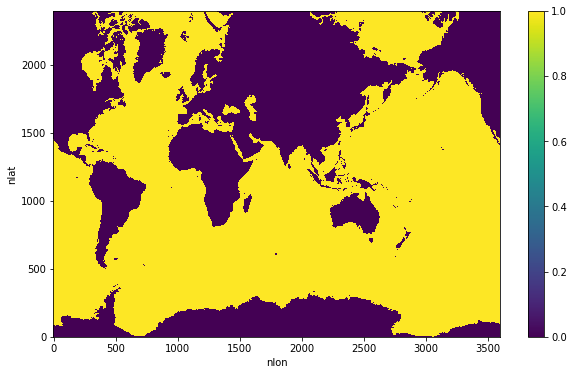

In [5]:
wet_mask = xr.where(ds['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

The area of the T-cells is

In [6]:
area = ds.TAREA / 10000  # convert units from cm2 to m2

## Filtering on CPUs

We tell `gcm-filters` to filter on CPU's by providing a `wet_mask` and input data that are **NumPy Arrays** or **Dask Arrays with NumPy chunks** (rather than CuPy Arrays or Dask Arrays with CuPy chunks).

In [7]:
wet_mask = wet_mask.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk
wet_mask

<xarray.DataArray 'KMT' (nlat: 2400, nlon: 3600)>
dask.array<xarray-<this-array>, shape=(2400, 3600), dtype=int64, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

In [8]:
area = area.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk
area

<xarray.DataArray 'TAREA' (nlat: 2400, nlon: 3600)>
dask.array<xarray-<this-array>, shape=(2400, 3600), dtype=float64, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

In [9]:
sst = ds.SST.where(wet_mask)
sst = sst.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk
sst

<xarray.DataArray 'SST' (time: 1, nlat: 2400, nlon: 3600)>
dask.array<where, shape=(1, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    units:      degC
    long_name:  Surface Potential Temperature

These are our filter specs (see also the section on simple fixed factor filters in [this tutorial](https://gcm-filters.readthedocs.io/en/latest/tutorial_filter_types.html)):

In [10]:
specs = {
    'filter_scale': 10,
    'dx_min': 1,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
    'grid_type': gcm_filters.GridType.TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND
}

We now create our CPU-compatible filter with our **NumPy**-based `area` and `wet_mask`.

In [11]:
filter_cpu = gcm_filters.Filter(grid_vars={'area': area, 'wet_mask': wet_mask}, **specs)
filter_cpu

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND: 6>)

Next, we filter the **NumPy**-based `SST` lazily on the CPU's with the simple fixed factor filter.

In [12]:
filtered_cpu = filter_cpu.apply(sst, dims=['nlat', 'nlon'])
filtered_cpu

<xarray.DataArray (time: 1, nlat: 2400, nlon: 3600)>
dask.array<truediv, shape=(1, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
    ULONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

Nothing has actually been computed yet. Let's trigger computation.

In [13]:
%time filtered_cpu = filtered_cpu.compute()

CPU times: user 2.7 s, sys: 1.88 s, total: 4.58 s
Wall time: 4.57 s


Here is a comparison of unfiltered vs. filtered SST, zoomed into the Gulf Stream region.

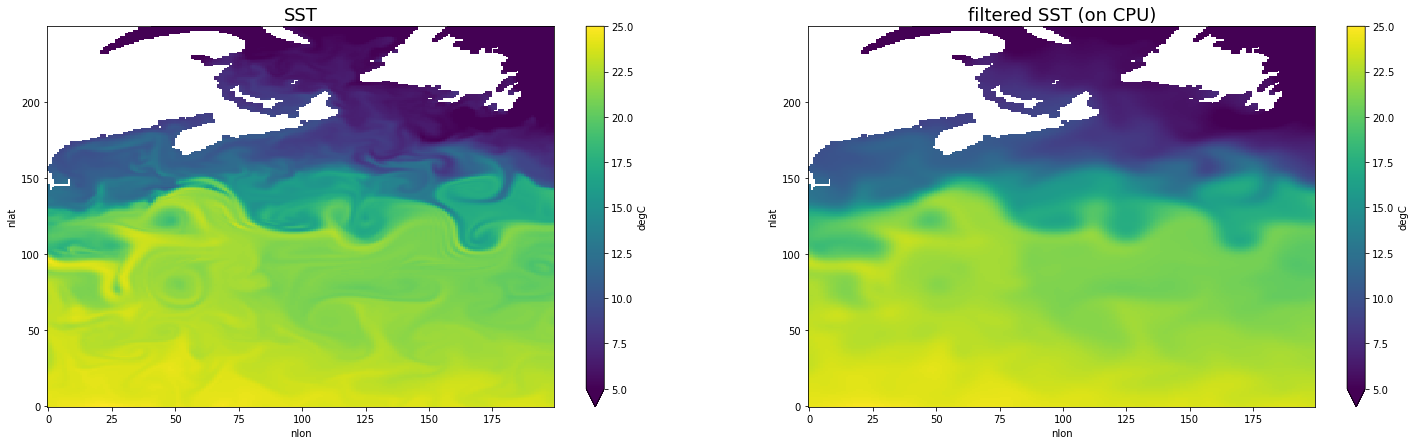

In [14]:
import matplotlib.pyplot as plt

vmin = 5
vmax = 25
yslice = slice(1500, 1750)
xslice = slice(400, 600)

fig,axs = plt.subplots(1,2,figsize=(25,7))
sst.isel(nlat=yslice, nlon=xslice).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cbar_kwargs={'label': 'degC'}
)
axs[0].set_title('SST', fontsize=18)
filtered_cpu.isel(nlat=yslice, nlon=xslice).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cbar_kwargs={'label': 'degC'}
)
axs[1].set_title('filtered SST (on CPU)', fontsize=18);

## Filtering on GPUs

We tell `gcm-filters` to filter on GPU's by providing a `wet_mask` and input data that are **CuPy Arrays** or **Dask Arrays with CuPy chunks**. We therefore have to map the NumPy chunks to CuPy chunks.

In [15]:
import cupy as cp

In [16]:
wet_mask_gpu = wet_mask.copy()
wet_mask_gpu.data = wet_mask_gpu.data.map_blocks(cp.asarray)
wet_mask_gpu

<xarray.DataArray 'KMT' (nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(2400, 3600), dtype=int64, chunksize=(2400, 3600), chunktype=cupy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

In [17]:
sst_gpu = sst.copy()
sst_gpu.data = sst_gpu.data.map_blocks(cp.asarray)
sst_gpu

<xarray.DataArray 'SST' (time: 1, nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(1, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=cupy.ndarray>
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    units:      degC
    long_name:  Surface Potential Temperature

In [18]:
area_gpu = area.copy()
area_gpu.data = area_gpu.data.map_blocks(cp.asarray)
area_gpu

<xarray.DataArray 'TAREA' (nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(2400, 3600), dtype=float64, chunksize=(2400, 3600), chunktype=cupy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

We create the filter with the same filter specs as above, but now with **CuPy**-based `area` and `wet_mask`.

In [19]:
filter_gpu = gcm_filters.Filter(grid_vars={'area': area_gpu, 'wet_mask': wet_mask_gpu}, **specs)
filter_gpu

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND: 6>)

Filtering of the data works the same way as before, except that we apply our filter to our **CuPy**-based `SST`.

In [20]:
filtered_gpu = filter_gpu.apply(sst_gpu, dims=['nlat', 'nlon'])
filtered_gpu

<xarray.DataArray (time: 1, nlat: 2400, nlon: 3600)>
dask.array<truediv, shape=(1, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=cupy.ndarray>
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
    ULONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

In the next cell, we map the CuPy blocks back to NumPy blocks.

In [21]:
filtered_gpu.data = filtered_gpu.data.map_blocks(cp.asnumpy)
filtered_gpu

<xarray.DataArray (time: 1, nlat: 2400, nlon: 3600)>
dask.array<asnumpy, shape=(1, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
    ULONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

Filtering on GPU is quite a bit faster than on CPU above.

In [22]:
%time filtered_gpu = filtered_gpu.compute()

CPU times: user 224 ms, sys: 231 ms, total: 454 ms
Wall time: 997 ms


Plotting filtered SST gives the same plot as above (that's good!).

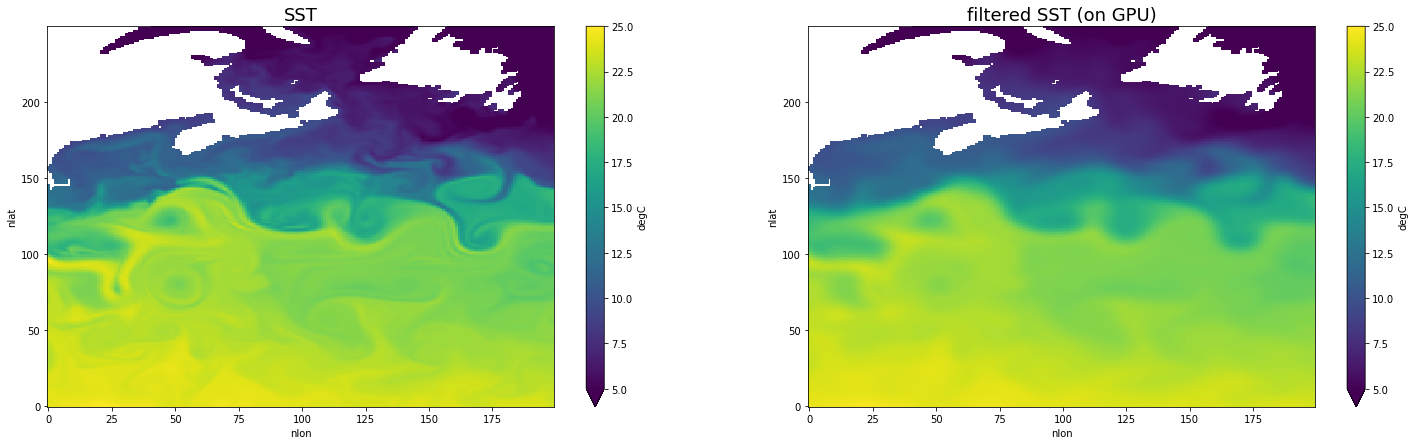

In [23]:
fig,axs = plt.subplots(1,2,figsize=(25,7))
sst.isel(nlat=yslice, nlon=xslice).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cbar_kwargs={'label': 'degC'}
)
axs[0].set_title('SST', fontsize=18)
filtered_gpu.isel(nlat=yslice, nlon=xslice).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cbar_kwargs={'label': 'degC'}
)
axs[1].set_title('filtered SST (on GPU)', fontsize=18);

Finally, we convince ourselves that the differences in the CPU- vs. GPU-filtered fields are as small as machine precision.

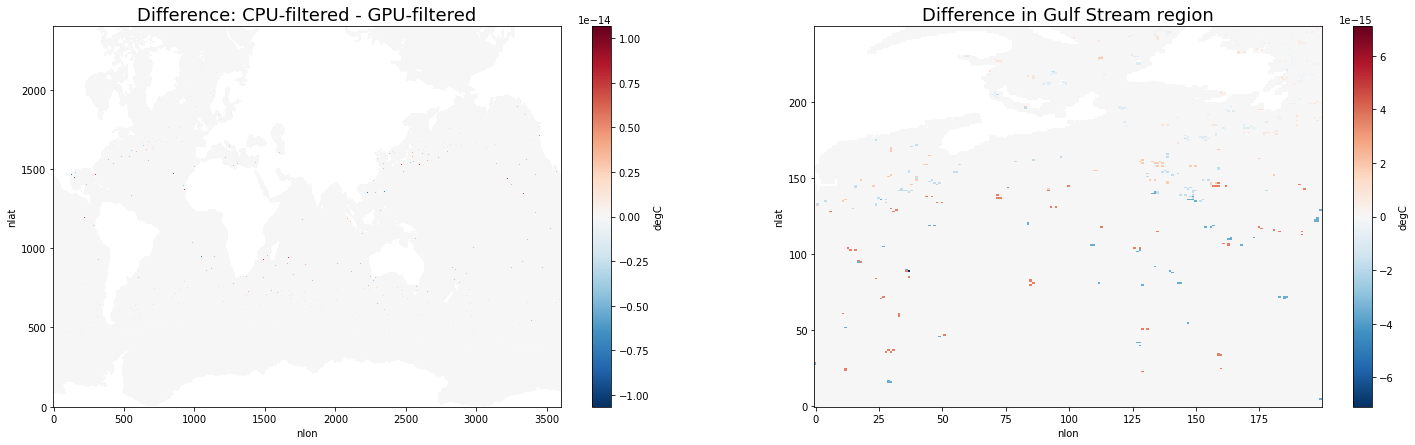

In [24]:
fig,axs = plt.subplots(1,2,figsize=(25,7))
(filtered_cpu-filtered_gpu).plot(
    ax=axs[0], 
    cbar_kwargs={'label': 'degC'}
)
axs[0].set_title('Difference: CPU-filtered - GPU-filtered', fontsize=18)
(filtered_cpu-filtered_gpu).isel(nlat=yslice, nlon=xslice).plot(
    ax=axs[1], 
    cbar_kwargs={'label': 'degC'}
)
axs[1].set_title('Difference in Gulf Stream region', fontsize=18);